In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


# Loading the processed data

In [2]:
df_long=pd.read_csv("student_engagement_analysis.csv")

# Special data processing for clustering

## Sample merge

Below is the number of samples for clustering if merge (id_student,code_module,code_presentation) as one sample

In [3]:
KEY=['id_student','code_module','code_presentation']
n_objects = df_long[KEY].drop_duplicates().shape[0]
print(n_objects)

25789


After group by the keys above, I have the description of rows of each samples

In [4]:
rows_per_object = df_long.groupby(KEY).size().sort_values(ascending=False)
rows_per_object.describe()

count    25789.000000
mean        62.174183
std         45.715904
min          1.000000
25%         30.000000
50%         54.000000
75%         80.000000
max        180.000000
dtype: float64

Also, I need to understand whether duplicated sample recording exists and where the duplicated coming from, therefore I add the next fearure, 'activity_type' in to the KEY and see the description

In [5]:
KEY2 = KEY + ["activity_type"]

n_unique_key2 = df_long[KEY2].drop_duplicates().shape[0]
print("unique (KEY+activity_type):", n_unique_key2)
print("avg rows per (KEY+activity_type):", len(df_long) / n_unique_key2)

counts_key2 = df_long.groupby(KEY2).size().sort_values(ascending=False)
counts_key2.head(10)

unique (KEY+activity_type): 222919
avg rows per (KEY+activity_type): 7.192792000681862


id_student  code_module  code_presentation  activity_type
2358423     DDD          2013B              ouelluminate     14
524396      DDD          2013B              homepage         14
                                            url              14
                                            subpage          14
                                            resource         14
                                            ouwiki           14
                                            ouelluminate     14
                                            oucontent        14
                                            forumng          14
558200      DDD          2013B              homepage         14
dtype: int64

Then based on the KEY2 groups, I count the total click for each activity of samples, preparing for transfer to the wide version.

In [6]:
tmp_engagement=(df_long
    .groupby(KEY2, as_index=False)
    .agg(
        sum_click=('sum', 'sum'),
        n_records=('activity_type','size')
    ))
print('After agg, duplicated KEY2', tmp_engagement.duplicated(KEY2).sum())
print('tmp shape', tmp_engagement.shape)
tmp_engagement.head(10)

After agg, duplicated KEY2 0
tmp shape (222919, 6)


,id_student,code_module,code_presentation,activity_type,sum_click,n_records
0,6516,AAA,2014J,dataplus,105,5
1,6516,AAA,2014J,forumng,2255,5
2,6516,AAA,2014J,homepage,2485,5
3,6516,AAA,2014J,oucontent,7525,5
4,6516,AAA,2014J,resource,155,5
5,6516,AAA,2014J,subpage,715,5
6,6516,AAA,2014J,url,715,5
7,8462,DDD,2013J,externalquiz,36,3
8,8462,DDD,2013J,forumng,108,3
9,8462,DDD,2013J,homepage,552,3


# Transfer to Wide Table

In [7]:
vle_sum_wide=(tmp_engagement.pivot(index=KEY, columns='activity_type',values='sum_click')
            .fillna(0)
            .add_prefix('vle_sum_click_'))

vle_sum_record=(tmp_engagement.pivot(index=KEY, columns='activity_type',values='n_records')
            .fillna(0)
            .add_prefix('vle_records_'))

overall= (tmp_engagement.groupby(KEY)
         .agg(
             total_click=('sum_click','sum'),
             total_record=('n_records','sum'),
             total_unique_activity=('activity_type','nunique')
         ))

X_engagement=pd.concat([vle_sum_wide, vle_sum_record], axis=1).reset_index()
X_engagement=X_engagement.merge(overall, on=KEY)
print('X_engagement duplicated number', X_engagement[KEY].duplicated().sum())
X_engagement.head(10)

X_engagement duplicated number 0


,id_student,code_module,code_presentation,vle_sum_click_dataplus,vle_sum_click_dualpane,vle_sum_click_externalquiz,vle_sum_click_folder,vle_sum_click_forumng,vle_sum_click_glossary,vle_sum_click_homepage,...,vle_records_questionnaire,vle_records_quiz,vle_records_repeatactivity,vle_records_resource,vle_records_sharedsubpage,vle_records_subpage,vle_records_url,total_click,total_record,total_unique_activity
0,6516,AAA,2014J,105.0,0.0,0.0,0.0,2255.0,0.0,2485.0,...,0.0,0.0,0.0,5.0,0.0,5.0,5.0,13955,35,7
1,8462,DDD,2013J,0.0,0.0,36.0,0.0,108.0,0.0,552.0,...,0.0,0.0,0.0,3.0,0.0,3.0,3.0,1938,27,9
2,8462,DDD,2014J,0.0,0.0,0.0,0.0,8.0,0.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,12,3
3,11391,AAA,2013J,0.0,0.0,0.0,0.0,965.0,0.0,690.0,...,0.0,0.0,0.0,5.0,0.0,5.0,5.0,4670,30,6
4,23629,BBB,2013B,0.0,0.0,0.0,0.0,348.0,0.0,144.0,...,0.0,4.0,0.0,4.0,0.0,4.0,0.0,644,20,5
5,23698,CCC,2014J,0.0,0.0,0.0,0.0,567.0,0.0,1089.0,...,0.0,9.0,0.0,9.0,0.0,9.0,9.0,8190,72,8
6,23798,BBB,2013J,0.0,0.0,0.0,0.0,1595.0,11.0,1859.0,...,0.0,11.0,0.0,11.0,0.0,11.0,11.0,6490,99,9
7,24186,GGG,2014B,0.0,0.0,0.0,0.0,112.0,0.0,368.0,...,0.0,8.0,0.0,8.0,0.0,8.0,0.0,1472,48,6
8,24213,DDD,2014B,0.0,0.0,63.0,0.0,5446.0,0.0,2275.0,...,0.0,0.0,0.0,7.0,0.0,7.0,7.0,13944,63,9
9,24391,GGG,2013J,0.0,0.0,0.0,0.0,558.0,18.0,1170.0,...,0.0,9.0,0.0,9.0,0.0,9.0,0.0,6408,63,7


I then found I could count the total sum of actiivity, click and record for each sample. Therefore, with and without these features may cause unpredicted influences.

In [8]:
KEY=['id_student','code_module','code_presentation']
Features_Without_Total=[c for c in X_engagement.columns
                        if c.startswith('vle_sum_click_') or c.startswith('vle_records_')]

Total=['total_click', 'total_record', 'total_unique_activity']

Features_With_Total=Features_Without_Total+Total

# Long-tail Data processing

From the plot below, shows the data of some features are 'long-tail', as an evidence of using 'log1p' to process

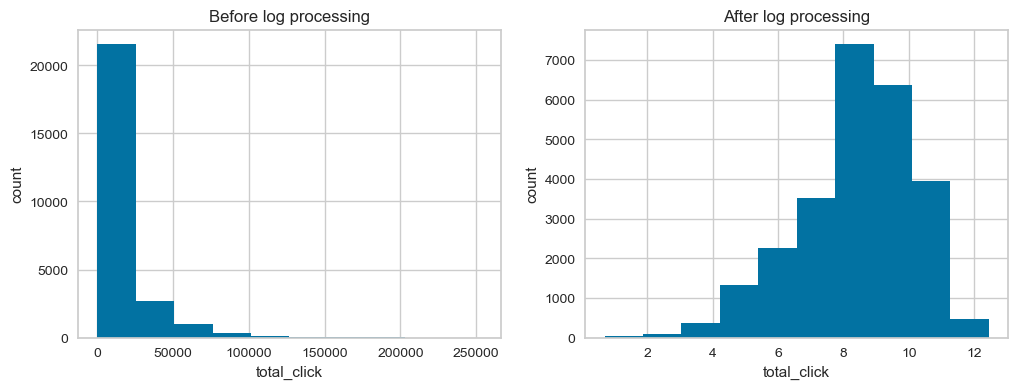

In [9]:
x=X_engagement['total_click']
fig,axes=plt.subplots(1,2,figsize=(12,4))

axes[0].hist(x,bins=10)
axes[0].set_title('Before log processing')
axes[0].set_xlabel('total_click')
axes[0].set_ylabel('count')

axes[1].hist(np.log1p(x),bins=10)
axes[1].set_title('After log processing')
axes[1].set_xlabel('total_click')
axes[1].set_ylabel('count')


plt.show()


Since the data is 0-inflated, in visualization, I only plotted the non-zero part to show the efficiency of log1p

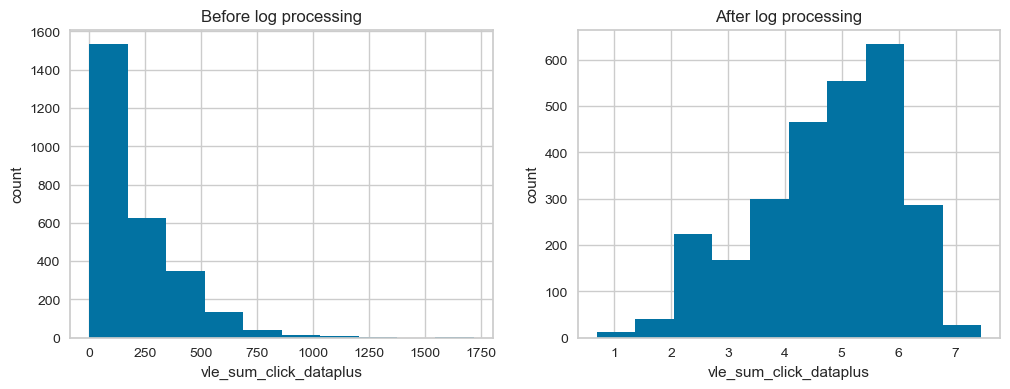

In [10]:

x=X_engagement['vle_sum_click_dataplus']
x=x[x>0]
fig,axes=plt.subplots(1,2,figsize=(12,4))

axes[0].hist(x,bins=10)
axes[0].set_title('Before log processing')
axes[0].set_xlabel('vle_sum_click_dataplus')
axes[0].set_ylabel('count')

axes[1].hist(np.log1p(x),bins=10)
axes[1].set_title('After log processing')
axes[1].set_xlabel('vle_sum_click_dataplus')
axes[1].set_ylabel('count')


plt.show()

# K-value decision

The value of k is strong related to the features I use, therefore, I first defined an interface to control whether the features use with or without the 'total' statistics

In [11]:
X_WithoutTotal=X_engagement[Features_Without_Total].copy()
X_WithoutTotal=np.log1p(X_WithoutTotal)

X_WithTotal=X_engagement[Features_With_Total].copy()
X_WithTotal=np.log1p(X_WithTotal)

Since the K-means is scaling sensitive, therefore I scaled the feature matrix first.

In [12]:
scaler_X_WithoutTotal=StandardScaler().fit_transform(X_WithoutTotal)
scaler_X_WithTotal=StandardScaler().fit_transform(X_WithTotal)


Below is for selection of data with/without Total features

In [13]:
X_using=scaler_X_WithTotal 

Below are Silhouette Scoring and Disortion Scoring for finding the 'best-k' from 2 to 10.

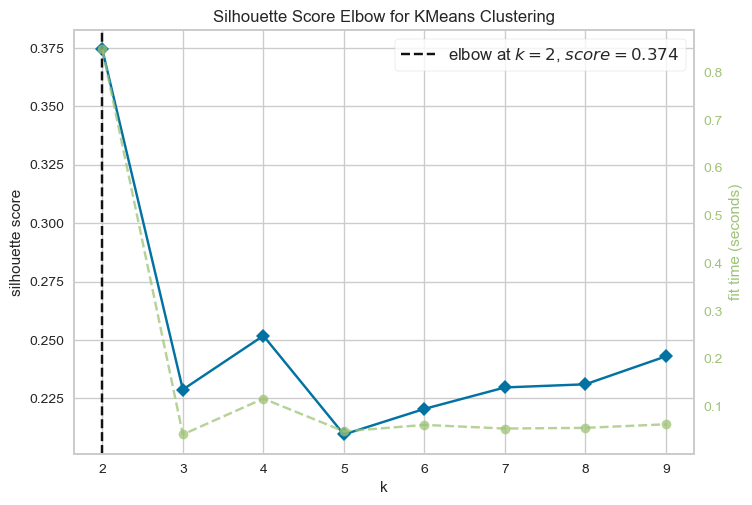

In [14]:
km=KMeans(random_state=42)

visualizer=KElbowVisualizer(
    km,
    k=(2,10),
    metric='silhouette',
    timings=True
)

visualizer.fit(X_using)
visualizer.show()
plt.show()

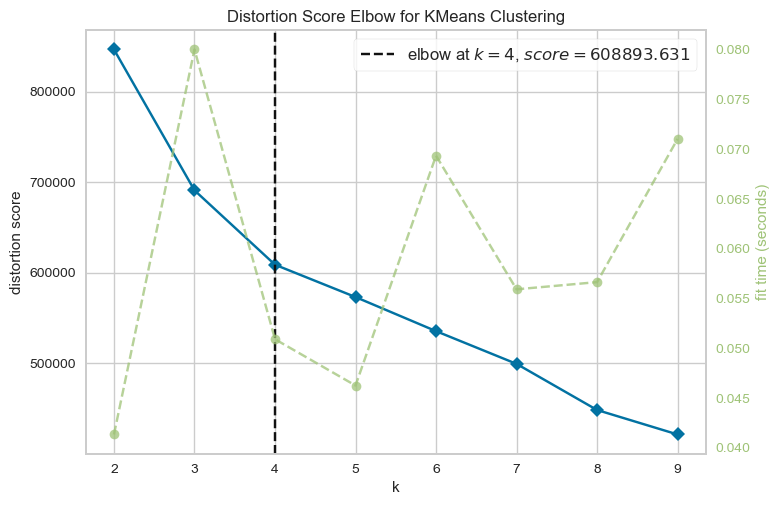

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
visualize_Elbow=KElbowVisualizer(
    km,
    k=(2,10),
    timings=True
)

visualize_Elbow.fit(X_using)
visualize_Elbow.show()

After the analysis on selection of k value, below is for k value selection

In [16]:
k_val=2 

# Model contribution and analysis

In [20]:
model=KMeans(n_clusters=k_val, random_state=42, n_init='auto')
cluster=model.fit_predict(X_using)

X_engagement['cluster']=cluster
X_engagement['cluster'].value_counts()


cluster
0    21300
1     4489
Name: count, dtype: int64

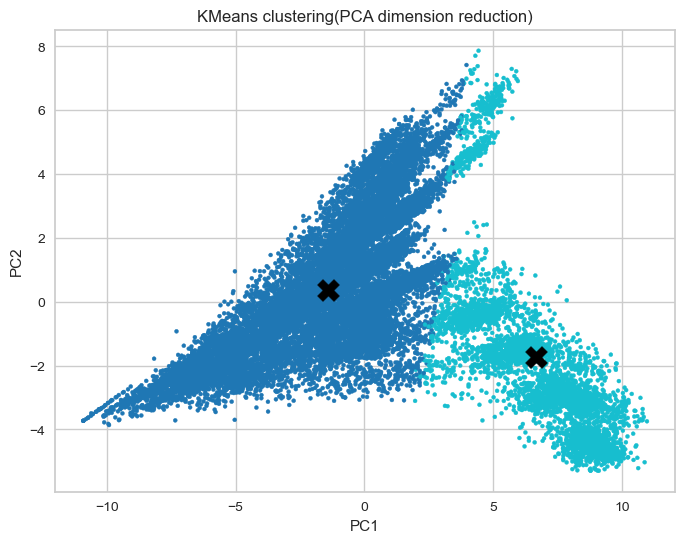

In [23]:
pca=PCA(n_components=2, random_state=42)
X_using_2d=pca.fit_transform(X_using)
centroid_2d=pca.transform(model.cluster_centers_)

plt.figure(figsize=(8,6))
plt.scatter(X_using_2d[:,0], 
            X_using_2d[:,1],
            c=cluster,
            s=8,
            cmap='tab10')
plt.scatter(centroid_2d[:,0], centroid_2d[:,1], marker='X', s=250, c='black', label='Centroid')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans clustering(PCA dimension reduction)')
plt.show()

C:\Users\YifanWang\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


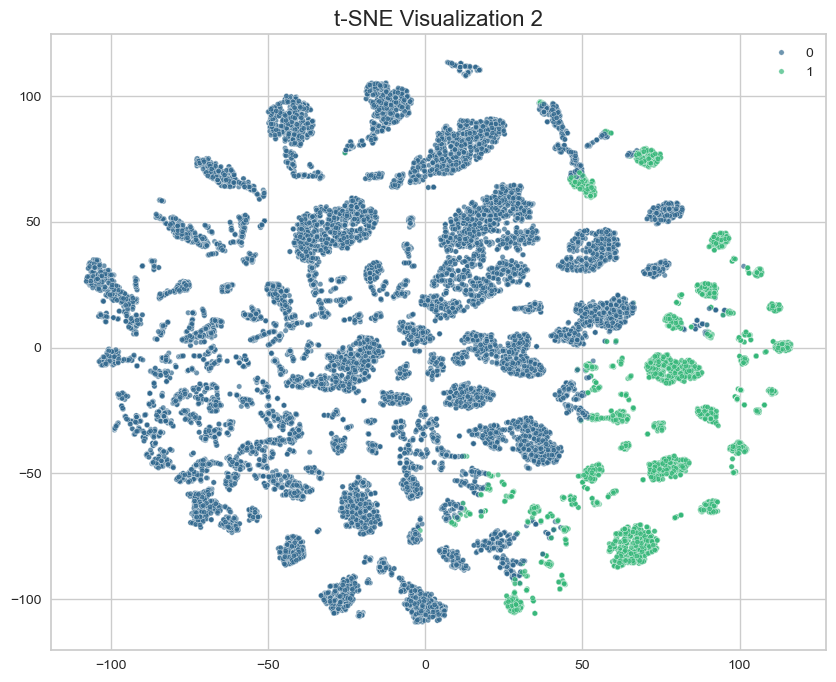

In [24]:

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_using)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:, 0], 
    y=X_tsne[:, 1], 
    hue=cluster,
    palette='viridis', 
    s=15, 
    alpha=0.7
)
plt.title(f't-SNE Visualization {k_val}', fontsize=16)
plt.show()

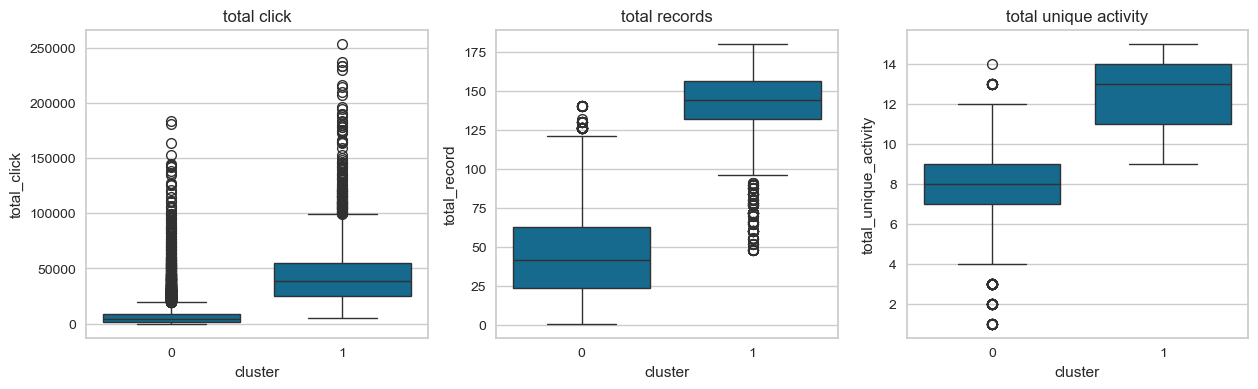

In [25]:
if  X_using is scaler_X_WithoutTotal:
    fig, axes = plt.subplots(1,4,figsize=(15,4))
    sns.boxplot(x='cluster', 
                y='vle_sum_click_dataplus',
                data=X_engagement,
                ax=axes[0])
    axes[0].set_title('click on dataplus')
    
    sns.boxplot(x='cluster', 
                y='vle_records_dataplus',
                data=X_engagement,
                ax=axes[1])
    axes[1].set_title('records of dataplus')
    
    sns.boxplot(x='cluster', 
                y='vle_sum_click_questionnaire',
                data=X_engagement,
                ax=axes[2])
    axes[2].set_title('click on questionnaire')
    
    sns.boxplot(x='cluster', 
                y='vle_records_questionnaire',
                data=X_engagement,
                ax=axes[3])
    axes[3].set_title('records of questionnaire')

if  X_using is scaler_X_WithTotal:
    fig, axes = plt.subplots(1,3,figsize=(15,4))
    sns.boxplot(x='cluster', 
                y='total_click',
                data=X_engagement,
                ax=axes[0])
    axes[0].set_title('total click')
    
    sns.boxplot(x='cluster', 
                y='total_record',
                data=X_engagement,
                ax=axes[1])
    axes[1].set_title('total records')
    
    sns.boxplot(x='cluster', 
                y='total_unique_activity',
                data=X_engagement,
                ax=axes[2])
    axes[2].set_title('total unique activity')
    
plt.show()

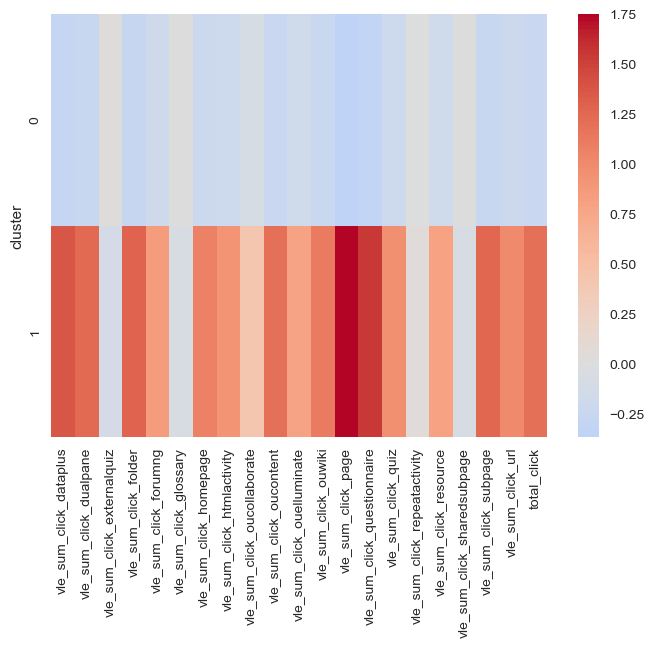

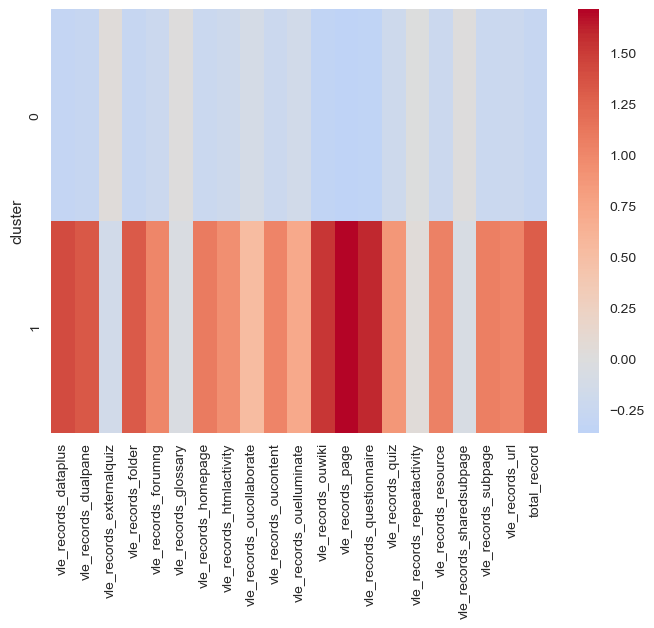

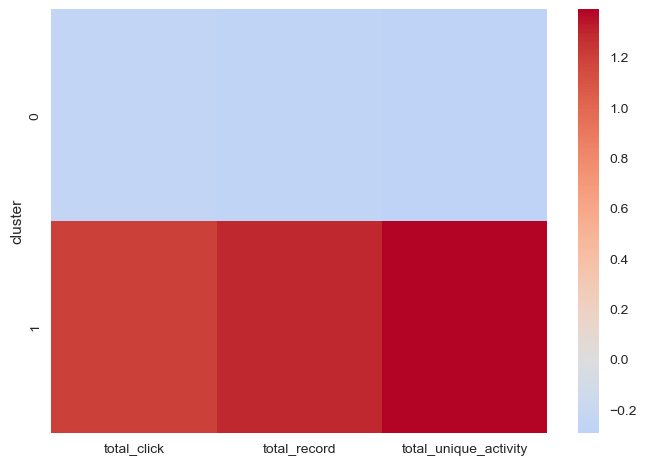

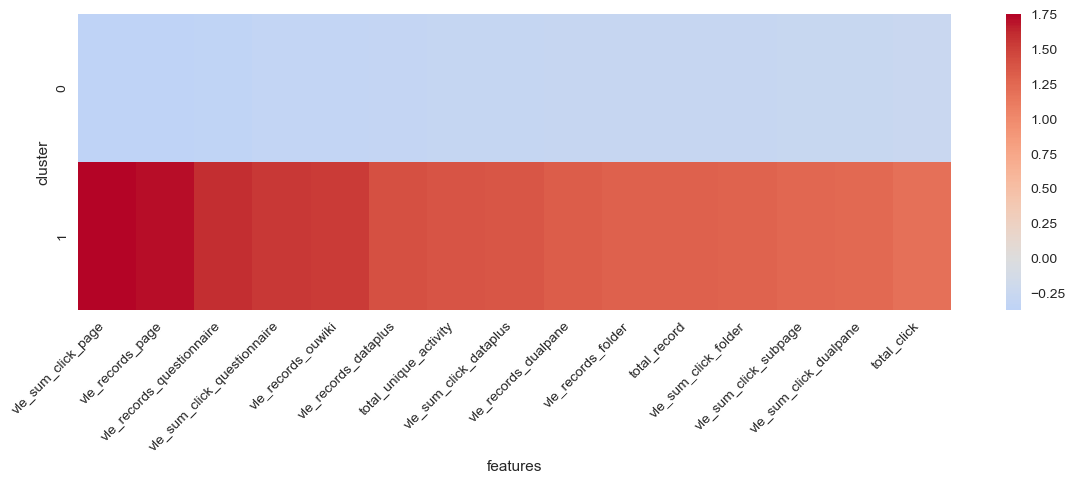

In [26]:
if X_using is scaler_X_WithTotal:
    X_std_df=pd.DataFrame(X_using, columns=Features_With_Total)
else:
    X_std_df=pd.DataFrame(X_using, columns=Features_Without_Total)
X_std_df['cluster']=X_engagement['cluster'].to_numpy()


def plot_heatmap(cols):
    cluster_profile = X_std_df[cols+['cluster']].groupby('cluster').mean()
    sns.heatmap(cluster_profile, cmap='coolwarm', center=0)
    plt.ylabel('cluster')
    plt.show()

click_cols=[c for c in X_std_df.columns if 'click' in c]
records_cols=[c for c in X_std_df.columns if 'record' in c]

plot_heatmap(click_cols)
plot_heatmap(records_cols)
if X_using is scaler_X_WithTotal:
    total_cols=[c for c in X_std_df.columns if 'total' in c]
    plot_heatmap(total_cols)

cluster_profile_all = X_std_df.groupby('cluster').mean()
sep_score = cluster_profile_all.var(axis=0).sort_values(ascending=False)

top_n = 15
top_features = sep_score.index[:top_n]
cluster_profile_top = cluster_profile_all[top_features]

plt.figure(figsize=(12, 5))
sns.heatmap(cluster_profile_top, cmap='coolwarm', center=0)

plt.ylabel('cluster')
plt.xlabel('features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




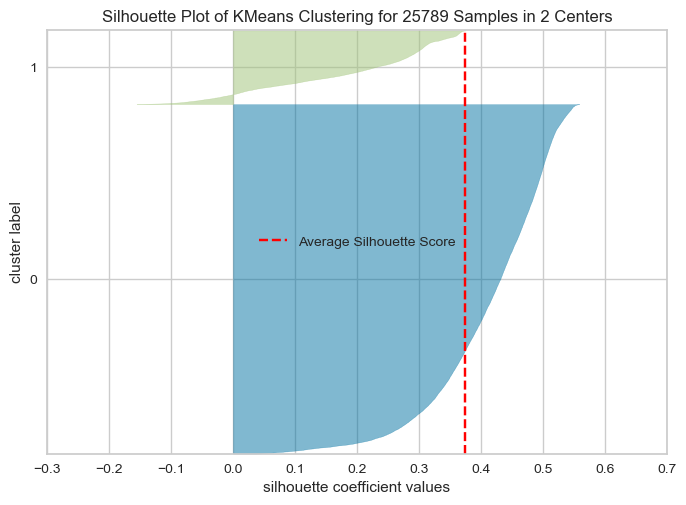

Average silhouette score: 0.3743537642437736


In [27]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_using)
visualizer.show()
plt.show()

# Average silhouette score
print('Average silhouette score:', visualizer.silhouette_score_)

In [28]:
df_cluster_result=X_engagement.merge(
    df_long[KEY+['final_result']],
    on=KEY,
    how='left'
)

df_cluster_result_unique=(
    df_cluster_result
    .drop_duplicates(subset=KEY)
    .reset_index(drop=True)
)
df_cluster_result_unique.head(10)


,id_student,code_module,code_presentation,vle_sum_click_dataplus,vle_sum_click_dualpane,vle_sum_click_externalquiz,vle_sum_click_folder,vle_sum_click_forumng,vle_sum_click_glossary,vle_sum_click_homepage,...,vle_records_repeatactivity,vle_records_resource,vle_records_sharedsubpage,vle_records_subpage,vle_records_url,total_click,total_record,total_unique_activity,cluster,final_result
0,6516,AAA,2014J,105.0,0.0,0.0,0.0,2255.0,0.0,2485.0,...,0.0,5.0,0.0,5.0,5.0,13955,35,7,0,Pass
1,8462,DDD,2013J,0.0,0.0,36.0,0.0,108.0,0.0,552.0,...,0.0,3.0,0.0,3.0,3.0,1938,27,9,0,Withdrawn
2,8462,DDD,2014J,0.0,0.0,0.0,0.0,8.0,0.0,28.0,...,0.0,0.0,0.0,0.0,0.0,40,12,3,0,Withdrawn
3,11391,AAA,2013J,0.0,0.0,0.0,0.0,965.0,0.0,690.0,...,0.0,5.0,0.0,5.0,5.0,4670,30,6,0,Pass
4,23629,BBB,2013B,0.0,0.0,0.0,0.0,348.0,0.0,144.0,...,0.0,4.0,0.0,4.0,0.0,644,20,5,0,Fail
5,23698,CCC,2014J,0.0,0.0,0.0,0.0,567.0,0.0,1089.0,...,0.0,9.0,0.0,9.0,9.0,8190,72,8,0,Pass
6,23798,BBB,2013J,0.0,0.0,0.0,0.0,1595.0,11.0,1859.0,...,0.0,11.0,0.0,11.0,11.0,6490,99,9,0,Distinction
7,24186,GGG,2014B,0.0,0.0,0.0,0.0,112.0,0.0,368.0,...,0.0,8.0,0.0,8.0,0.0,1472,48,6,0,Pass
8,24213,DDD,2014B,0.0,0.0,63.0,0.0,5446.0,0.0,2275.0,...,0.0,7.0,0.0,7.0,7.0,13944,63,9,0,Pass
9,24391,GGG,2013J,0.0,0.0,0.0,0.0,558.0,18.0,1170.0,...,0.0,9.0,0.0,9.0,0.0,6408,63,7,0,Distinction


Below are analysis of the final_result in each clustering

In [29]:

cluster_class = pd.crosstab(
    df_cluster_result_unique["cluster"],
    df_cluster_result_unique["final_result"],
    normalize="index"
)

cluster_class

final_result,Distinction,Fail,Pass,Withdrawn
cluster,,,,
0,0.109155,0.244883,0.432066,0.213897
1,0.155714,0.116730,0.702384,0.025173


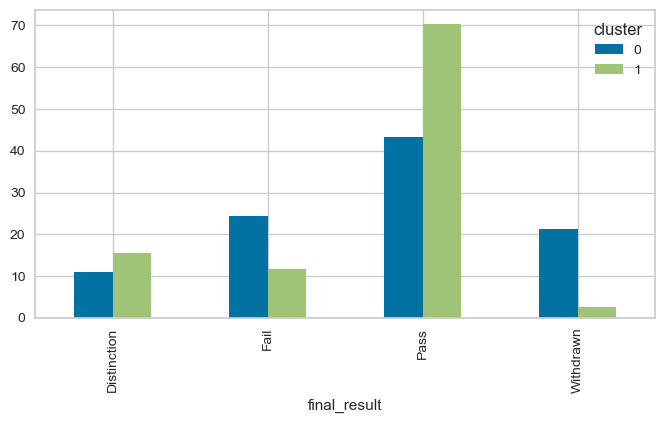

In [30]:
ax = (cluster_class.T * 100).plot(kind="bar", figsize=(8,4))

In [21]:
cluster1=model.fit_predict(scaler_X_WithoutTotal)
cluster2=model.fit_predict(scaler_X_WithTotal)

ari = adjusted_rand_score(cluster1, cluster2)
nmi = normalized_mutual_info_score(cluster1, cluster2)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

Adjusted Rand Index (ARI): 0.9769
Normalized Mutual Information (NMI): 0.9445
